In [2]:
from datetime import datetime, timedelta
import pytz
import math

import pandas as pd
import numpy as np

# TODO: get list of pseudonyms, (valid) dates and reference parameters from Excel file  
homes =  [886307, 873985, 817341]

#location: center of Assendorp neighbourhood in Zwolle
lat, lon = 52.5065500000, 6.0996100000

#timezone: 
tz_home = 'Europe/Amsterdam'

# first test just a short timeseries
start = pytz.timezone(tz_home).localize(datetime(2021, 12, 20))
end = pytz.timezone(tz_home).localize(datetime(2022, 3, 16))

# date and times of seemingly valid periods for short set of 3 
# 886307	2021-12-19 18:55	2022-03-17 09:37
# 873985	2021-12-20 12:54	2022-03-17 17:54
# 817341	2022-01-14 20:27	2022-03-17 18:15

    
# utimately: #min, max dates of the analysis
# start = pytz.timezone(tz_home).localize(datetime(2021,10,21))
# stop = pytz.timezone(tz_home).localize(datetime(2022,5,12)

In [3]:
start

datetime.datetime(2021, 12, 20, 0, 0, tzinfo=<DstTzInfo 'Europe/Amsterdam' CET+1:00:00 STD>)

In [4]:
end

datetime.datetime(2022, 3, 16, 0, 0, tzinfo=<DstTzInfo 'Europe/Amsterdam' CET+1:00:00 STD>)

In [5]:
%%time 
#get geospatially interpolated weather from KNMI 

import sys
sys.path.append('../data/')
from extractor import WeatherExtractor

import tqdm
upsample = '5min'
downsample = '15min'

weather = WeatherExtractor.get_linear_geospatial_interpolation_weather_nl(start, end, lat, lon, tz_home)

Model 2


/home/jovyan/twomes-analysis-pipeline/src/historicdutchweather/historicdutchweather/main.py:67: DtypeWarning: Columns (15,20,21,22,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url, comment="#", skiprows=30, skip_blank_lines=True, names=__headerline)
/home/jovyan/twomes-analysis-pipeline/src/historicdutchweather/historicdutchweather/main.py:67: DtypeWarning: Columns (3,4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url, comment="#", skiprows=30, skip_blank_lines=True, names=__headerline)


Got a value error for station 258
Will skip for now


/home/jovyan/twomes-analysis-pipeline/src/historicdutchweather/historicdutchweather/main.py:67: DtypeWarning: Columns (3,15,20,21,22,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url, comment="#", skiprows=30, skip_blank_lines=True, names=__headerline)


Got a value error for station 275
Will skip for now


100% 2064/2064 [00:28<00:00, 72.51it/s]

CPU times: user 31.1 s, sys: 745 ms, total: 31.9 s
Wall time: 33.1 s


In [6]:
%%time 
print('Resampling weather data...' )
outdoor_temp_by_day = WeatherExtractor.get_weather_parameter_timeseries_mean(weather, 'T', 'outdoor_temp_degC', 
                                                            upsample, downsample, start, end, tz_home)

windspeed_by_day = WeatherExtractor.get_weather_parameter_timeseries_mean(weather, 'FH', 'windspeed_m_per_s', 
                                                            upsample, downsample, start, end, tz_home)
irradiation_by_day = WeatherExtractor. get_weather_parameter_timeseries_mean(weather, 'Q', 'hor_irradiation_J_per_h_per_cm^2', 
                                                            upsample, downsample, start, end, tz_home)

# merge weather data in a single dataframe
weather_by_day = pd.concat([outdoor_temp_by_day, windspeed_by_day, irradiation_by_day], axis=1, join='outer') 
#calculate effective outdoor temperature based on KNMI formula
weather_by_day['effective_outdoor_temp_degC'] = weather_by_day['outdoor_temp_degC'] - 2/3 * weather_by_day['windspeed_m_per_s'] 

weather_by_day['hor_irradiation_W_per_m^2'] = weather_by_day['hor_irradiation_J_per_h_per_cm^2']  * (100 * 100) / (60 * 60)

Resampling weather data...
CPU times: user 43 ms, sys: 56 µs, total: 43.1 ms
Wall time: 41.5 ms


Text(0, 0.5, "<class 'property'>")

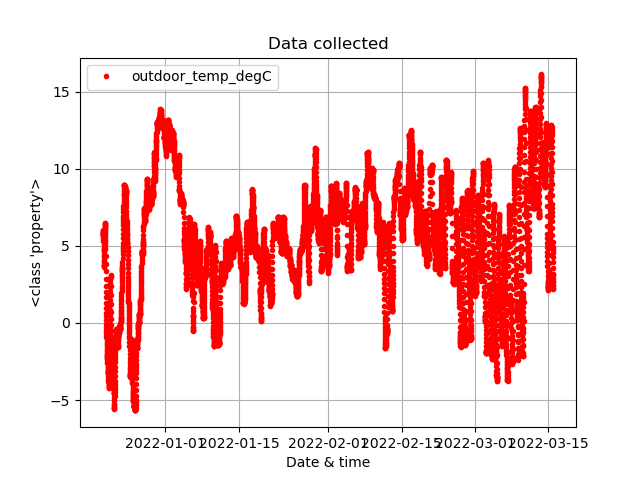

In [7]:
# plot temperature data

%matplotlib widget
import pylab as plt

fig, ax = plt.subplots()

ax.grid(True)
ax.plot(outdoor_temp_by_day.index, outdoor_temp_by_day['outdoor_temp_degC'], '.', label='outdoor_temp_degC', color='r')
ax.legend(loc=0)

ax.set_xlabel('Date & time')  
ax.set_ylabel(r'$T_{in} [^oC]$')
ax.set_title('Data collected')  

plt.ylabel(property)


# N.B. The resulting figure below can be manipulated interactively; hover with mouse for tips & tricks

In [8]:
# use of the database requires the .env file in the root folder of the repo to be filled with the proper credentials

import scipy.optimize
import scipy.interpolate

import sys
sys.path.append('../data/')
from extractor import Extractor, Period
import openpyxl
    

In [9]:
%%time 

# this cell tests whether data can be retrieved



data_by_day_total = pd.DataFrame()

print('Retrieving data for pseudonym...' )


pseudonym = 873985
print(pseudonym)
extractor = Extractor(pseudonym, Period(start, end))


property = 'roomTemp'
# property = ['roomTemp', 'pump']


timeseriesdata = extractor.get(property)
print (timeseriesdata['value'].dtypes)
timeseriesdata['value'] = timeseriesdata['value'].astype(float)
print (timeseriesdata['value'].dtypes)
timeseriesdata.describe()
print(timeseriesdata)


Retrieving data for pseudonym...
873985
object
float64
          index  value            datetime   timestamp
0        830810  20.30 2021-12-20 00:03:41  1639958621
1        830811  20.00 2021-12-20 00:08:41  1639958921
2        830812  19.80 2021-12-20 00:13:41  1639959221
3        830813  20.19 2021-12-20 00:18:41  1639959521
4        830814  19.90 2021-12-20 00:23:41  1639959821
...         ...    ...                 ...         ...
16257  32203457   0.00 2022-03-12 02:58:31  1647053911
16258  32274997   0.00 2022-03-12 07:26:35  1647069995
16259  32439107   0.00 2022-03-12 17:12:08  1647105128
16260  33244477   0.00 2022-03-14 15:45:31  1647272731
16261  33576603   0.00 2022-03-15 11:45:09  1647344709

[16262 rows x 4 columns]
CPU times: user 74.6 ms, sys: 5.98 ms, total: 80.6 ms
Wall time: 8.73 s


In [10]:
timeseriesdata

,index,value,datetime,timestamp
0,830810,20.30,2021-12-20 00:03:41,1639958621
1,830811,20.00,2021-12-20 00:08:41,1639958921
2,830812,19.80,2021-12-20 00:13:41,1639959221
3,830813,20.19,2021-12-20 00:18:41,1639959521
4,830814,19.90,2021-12-20 00:23:41,1639959821
...,...,...,...,...
16257,32203457,0.00,2022-03-12 02:58:31,1647053911
16258,32274997,0.00,2022-03-12 07:26:35,1647069995
16259,32439107,0.00,2022-03-12 17:12:08,1647105128
16260,33244477,0.00,2022-03-14 15:45:31,1647272731


Text(0, 0.5, 'roomTemp')

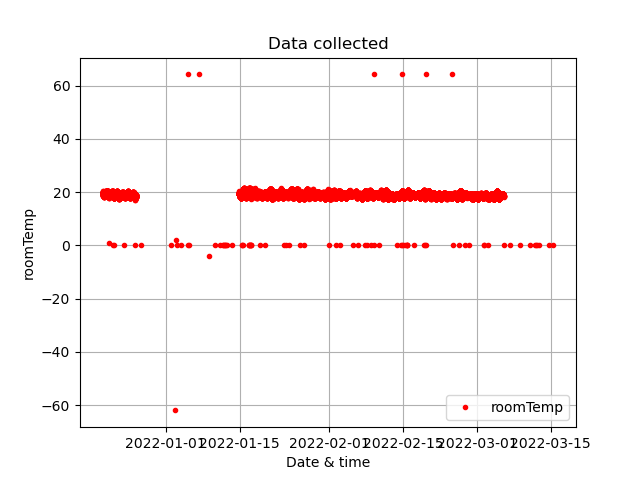

In [11]:
# plot temperature data

%matplotlib widget
import pylab as plt

fig, ax = plt.subplots()

ax.grid(True)
ax.plot(timeseriesdata.datetime, timeseriesdata.value, '.', label=property, color='r')  
ax.legend(loc=0)
ax.set_xlabel('Date & time')
ax.set_ylabel(r'$T_{in} [^oC]$')
ax.set_title('Data collected')

plt.ylabel(property)


# N.B. The resulting figure below can be manipulated interactively; hover with mouse for tips & tricks

In [12]:
timeseriesdata2 = WeatherExtractor.remove_weather_outliers(timeseriesdata, ['value'], 3.0)

In [13]:
timeseriesdata

,index,value,datetime,timestamp
0,830810.0,20.30,2021-12-20 00:03:41,1.639959e+09
1,830811.0,20.00,2021-12-20 00:08:41,1.639959e+09
2,830812.0,19.80,2021-12-20 00:13:41,1.639959e+09
3,830813.0,20.19,2021-12-20 00:18:41,1.639960e+09
4,830814.0,19.90,2021-12-20 00:23:41,1.639960e+09
...,...,...,...,...
16257,NaN,NaN,NaT,NaN
16258,NaN,NaN,NaT,NaN
16259,NaN,NaN,NaT,NaN
16260,NaN,NaN,NaT,NaN


Text(0, 0.5, 'roomTemp')

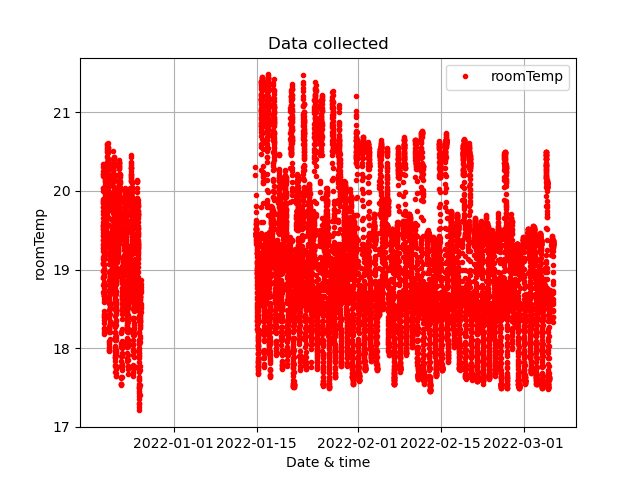

In [14]:
# this cell tests plotting of data retrieved

%matplotlib widget
import pylab as plt

fig, ax = plt.subplots()

ax.grid(True)
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)

# ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
# ax2.set_ylabel(r'$I\ [J/(h \bullet m^2)]$')
# ax2.plot(weather.index, weather['Q'], '.', label='global horizontal irradiation', alpha=0.5, color='y')  # ... and some more.
# ax2.legend(loc=1)

ax.plot(timeseriesdata2.datetime, timeseriesdata2.value, '.', label=property, color='r')  # Plot some data on the axes.
# ax.plot(weather.index, weather['FH'], '.', label='wind speed', color='c')  # Plot more data on the axes...
# ax.plot(weather.index, weather['T'] - 2/3 * weather['FH'], '.', label='effective outdoor temperature', color='orange')  # Plot more data on the axes...
ax.legend(loc=0);  # Add a legend.

ax.set_xlabel('Date & time')  # Add an x-label to the axes.
ax.set_ylabel(r'$T_{in} [^oC]$')
ax.set_title('Data collected')  # Add a title to the axes.

plt.ylabel(property)


# N.B. The resulting figure below can be manipulated interactively; hover with mouse for tips & tricks

In [15]:
data_by_day_total = pd.DataFrame()

print('Retrieving data for pseudonyms...' )


# TODO:convert list of pseudonyms to function call that uses database, something like 
# pseudonymlist = extractor.get_accounts()

for pseudonym in tqdm.tqdm(homes):
    # print(pseudonym)
    extractor = Extractor(pseudonym, Period(start, end))
    # print('...getting heartbeat')
    heartbeats_by_day = extractor.get_home_parameter_timeseries_count('heartbeat', 'heartbeat', False, upsample, downsample, start, end, tz_home)
    
    # print('...getting indoor_temp_degC')
    indoor_temp_by_day = extractor.get_home_parameter_timeseries_mean('roomTemp', 'indoor_temp_degC', 
                                                            upsample, downsample, start, end, tz_home)

    # print('...getting indoor_temp_degC_CO2')
    indoor_temp_by_day_CO2 = extractor.get_home_parameter_timeseries_mean('roomTempCO2', 'indoor_temp_degC_CO2', 
                                                            upsample, downsample, start, end, tz_home)  
    # print('...getting indoor_setpoint_temp_degC')
    indoor_setpoint_by_day = extractor.get_indoor_setpoint_timeseries_mean('roomSetpointTemp', 'indoor_setpoint_temp_degC',
                                                            upsample, downsample, start, end, tz_home)
    if len(indoor_temp_by_day.index)>=1:
        # print('...getting gas_m^3')
        gas_m3_by_day = extractor.get_meter_parameter_timeseries_sum('gMeterReadingSupply', 'gas_m^3', 
                                         True, upsample, downsample, start, end, tz_home)
        # print('...getting e_used_normal_kWh')
        e_used_normal_kWh_by_day = extractor.get_meter_parameter_timeseries_sum('eMeterReadingSupplyHigh', 'e_used_normal_kWh', 
                                         True, upsample, downsample, start, end, tz_home)
        # print('...getting e_used_low_kWh')
        e_used_low_kWh_by_day = extractor.get_meter_parameter_timeseries_sum('eMeterReadingSupplyLow', 'e_used_low_kWh', 
                                         True, upsample, downsample, start, end, tz_home)
        # print('...getting e_returned_normal_kWh')
        e_returned_normal_kWh_by_day = extractor.get_meter_parameter_timeseries_sum('eMeterReadingReturnHigh', 'e_returned_normal_kWh', 
                                         True, upsample, downsample, start, end, tz_home)
        # print('...getting e_returned_low_kWh')
        e_returned_low_kWh_by_day = extractor.get_meter_parameter_timeseries_sum('eMeterReadingReturnLow', 'e_returned_low_kWh', 
                                         True, upsample, downsample, start, end, tz_home)
    
        home_by_day = pd.concat([heartbeats_by_day, weather_by_day, indoor_temp_by_day, indoor_temp_by_day_CO2, 
                                 indoor_setpoint_by_day,
                                 gas_m3_by_day,
                                 e_used_normal_kWh_by_day, e_used_low_kWh_by_day,
                                 e_returned_normal_kWh_by_day, e_returned_low_kWh_by_day
                                ], axis=1, join='outer')    
    
        home_by_day['homepseudonym'] = pseudonym
        
        data_by_day = home_by_day.reindex(columns= ['homepseudonym', 'heartbeat',
                                                    'outdoor_temp_degC','windspeed_m_per_s', 'effective_outdoor_temp_degC', 'hor_irradiation_J_per_h_per_cm^2', 'hor_irradiation_W_per_m^2',  
                                                    'indoor_temp_degC', 'indoor_temp_degC_CO2', 'indoor_setpoint_temp_degC',
                                                    'gas_m^3',  
                                                    'e_used_normal_kWh', 'e_used_low_kWh', 
                                                    'e_returned_normal_kWh', 'e_returned_low_kWh'
                                                   ])
                
        
        data_by_day['timedelta'] = data_by_day.index.to_series().diff().shift(-1)
        data_by_day['timedelta_s'] = data_by_day['timedelta'].apply(lambda x: x.total_seconds())

        
        data_by_day_total = pd.concat([data_by_day_total, data_by_day], axis=0)
        data_by_day_total['e_used_net_kWh'] = (data_by_day_total['e_used_normal_kWh'] + data_by_day_total['e_used_low_kWh'] - data_by_day_total['e_returned_normal_kWh'] - data_by_day_total['e_returned_low_kWh'])
        
        data_by_day_total['e_remaining_heat_kWh'] = (data_by_day_total['e_used_net_kWh'])

        data_by_day_total['daycompleteness'] = (data_by_day_total['heartbeat'] / data_by_day_total['timedelta_s'] * 60 * 5)

#         filename = './'+str(pseudonym)+'.xlsx'
#         #strip timezone info before exporting to (Excel doet not support timezone)
#         data_by_day.tz_localize(None).to_excel(filename)
        
#         data_by_day_total.tz_localize(None, level=0).to_excel('./allhomes.xlsx')


Retrieving data for pseudonyms...


100% 3/3 [04:20<00:00, 86.87s/it]


In [16]:
timeseriesdata


,index,value,datetime,timestamp
0,830810.0,20.30,2021-12-20 00:03:41,1.639959e+09
1,830811.0,20.00,2021-12-20 00:08:41,1.639959e+09
2,830812.0,19.80,2021-12-20 00:13:41,1.639959e+09
3,830813.0,20.19,2021-12-20 00:18:41,1.639960e+09
4,830814.0,19.90,2021-12-20 00:23:41,1.639960e+09
...,...,...,...,...
16257,NaN,NaN,NaT,NaN
16258,NaN,NaN,NaT,NaN
16259,NaN,NaN,NaT,NaN
16260,NaN,NaN,NaT,NaN


In [17]:
timeseriesdata = Extractor.remove_measurement_outliers(timeseriesdata, 3.0)


In [18]:
timeseriesdata

,index,value,datetime,timestamp
0,830810.0,20.30,2021-12-20 00:03:41,1.639959e+09
1,830811.0,20.00,2021-12-20 00:08:41,1.639959e+09
2,830812.0,19.80,2021-12-20 00:13:41,1.639959e+09
3,830813.0,20.19,2021-12-20 00:18:41,1.639960e+09
4,830814.0,19.90,2021-12-20 00:23:41,1.639960e+09
...,...,...,...,...
16257,NaN,NaN,NaT,NaN
16258,NaN,NaN,NaT,NaN
16259,NaN,NaN,NaT,NaN
16260,NaN,NaN,NaT,NaN


In [19]:
data_by_day_total

,homepseudonym,heartbeat,outdoor_temp_degC,windspeed_m_per_s,effective_outdoor_temp_degC,hor_irradiation_J_per_h_per_cm^2,hor_irradiation_W_per_m^2,indoor_temp_degC,indoor_temp_degC_CO2,indoor_setpoint_temp_degC,gas_m^3,e_used_normal_kWh,e_used_low_kWh,e_returned_normal_kWh,e_returned_low_kWh,timedelta,timedelta_s,e_used_net_kWh,e_remaining_heat_kWh,daycompleteness
2021-12-20 00:00:00+01:00,886307,NaN,6.021051,1.604638,4.951292,-1.976263e-323,-5.434722e-323,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 days 00:15:00,900.0,NaN,NaN,NaN
2021-12-20 00:15:00+01:00,886307,NaN,5.981809,1.604638,4.912050,-1.976263e-323,-5.434722e-323,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 days 00:15:00,900.0,NaN,NaN,NaN
2021-12-20 00:30:00+01:00,886307,NaN,5.942567,1.604638,4.872808,-1.976263e-323,-5.434722e-323,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 days 00:15:00,900.0,NaN,NaN,NaN
2021-12-20 00:45:00+01:00,886307,NaN,5.903324,1.604638,4.833566,-1.976263e-323,-5.434722e-323,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 days 00:15:00,900.0,NaN,NaN,NaN
2021-12-20 01:00:00+01:00,886307,2.0,5.868830,1.583000,4.813496,-1.976263e-323,-5.434722e-323,16.746667,72.0,12.5,0.0,0.0,0.001,0.0,0.0,0 days 00:15:00,900.0,0.001,0.001,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-15 23:30:00+01:00,817341,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 days 00:15:00,900.0,NaN,NaN,1.000000
2022-03-15 23:45:00+01:00,817341,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 days 00:15:00,900.0,NaN,NaN,1.000000
2022-03-16 00:00:00+01:00,817341,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 days 00:15:00,900.0,NaN,NaN,1.000000
2022-03-16 00:15:00+01:00,817341,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 days 00:15:00,900.0,NaN,NaN,1.000000


In [20]:
df_sliced1 = data_by_day_total[data_by_day_total["homepseudonym"] ==  886307]

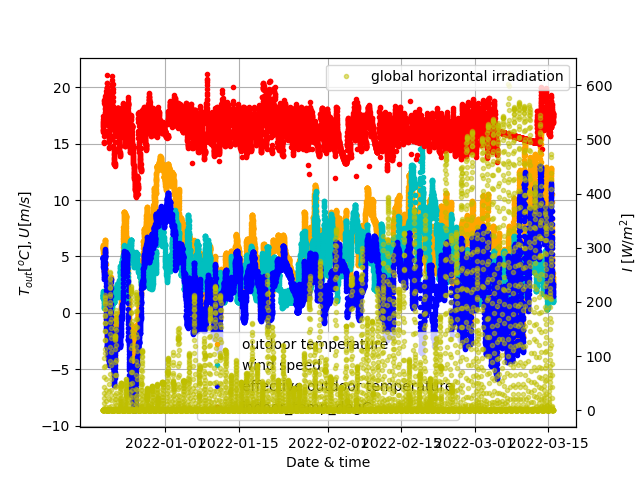

In [23]:
# plot retrieved data

property = 'indoor_temp_degC'

%matplotlib widget
import pylab as plt

fig, ax = plt.subplots()

ax.grid(True)
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)


ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel(r'$I\ [W/m^2]$')
ax2.plot(df_sliced1.index, df_sliced1['hor_irradiation_W_per_m^2'], '.', label='global horizontal irradiation', alpha=0.5, color='y')  # ... and some more.
ax2.legend(loc=1)

ax.plot(df_sliced1.index, df_sliced1['outdoor_temp_degC'], '.', label='outdoor temperature', color='orange')  # Plot some data on the axes.
ax.plot(df_sliced1.index, df_sliced1['windspeed_m_per_s'], '.', label='wind speed', color='c')  # Plot more data on the axes...
ax.plot(df_sliced1.index, df_sliced1['effective_outdoor_temp_degC'], '.', label='effective outdoor temperature', color='b')  # Plot more data on the axes...
ax.plot(df_sliced1.index, df_sliced1[property], '.', label=property, color='r')  # Plot some data on the axes.
ax.legend(loc=0);  # Add a legend.

ax.set_xlabel('Date & time')  # Add an x-label to the axes.
ax.set_ylabel(r'$T_{out} [^oC], U [m/s]$')
plt.show()

# N.B. The resulting figure below can be manipulated interactively; hover with mouse for tips & tricks

In [24]:
df_sliced2 = data_by_day_total[data_by_day_total["homepseudonym"] ==  873985]

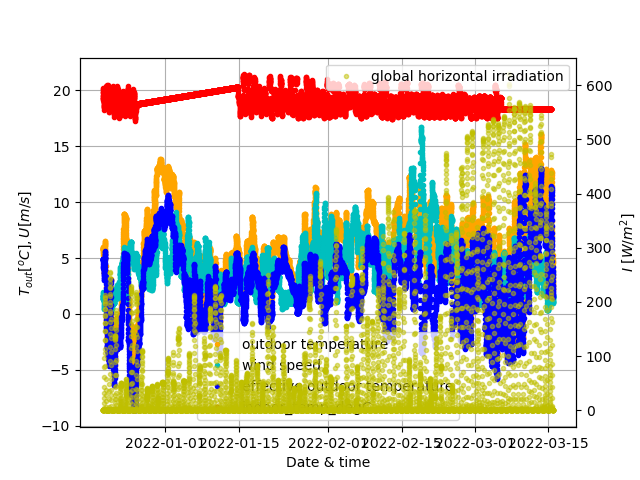

In [26]:
# plot retrieved data

property = 'indoor_temp_degC'

%matplotlib widget
import pylab as plt

fig, ax = plt.subplots()

ax.grid(True)
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)


ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel(r'$I\ [W/m^2]$')
ax2.plot(df_sliced2.index, df_sliced2['hor_irradiation_W_per_m^2'], '.', label='global horizontal irradiation', alpha=0.5, color='y')  # ... and some more.
ax2.legend(loc=1)

ax.plot(df_sliced2.index, df_sliced2['outdoor_temp_degC'], '.', label='outdoor temperature', color='orange')  # Plot some data on the axes.
ax.plot(df_sliced2.index, df_sliced2['windspeed_m_per_s'], '.', label='wind speed', color='c')  # Plot more data on the axes...
ax.plot(df_sliced2.index, df_sliced2['effective_outdoor_temp_degC'], '.', label='effective outdoor temperature', color='b')  # Plot more data on the axes...
ax.plot(df_sliced2.index, df_sliced2[property], '.', label=property, color='r')  # Plot some data on the axes.
ax.legend(loc=0);  # Add a legend.

ax.set_xlabel('Date & time')  # Add an x-label to the axes.
ax.set_ylabel(r'$T_{out} [^oC], U [m/s]$')
plt.show()

# N.B. The resulting figure below can be manipulated interactively; hover with mouse for tips & tricks

In [27]:
df_sliced3 = data_by_day_total[data_by_day_total["homepseudonym"] ==  817341]

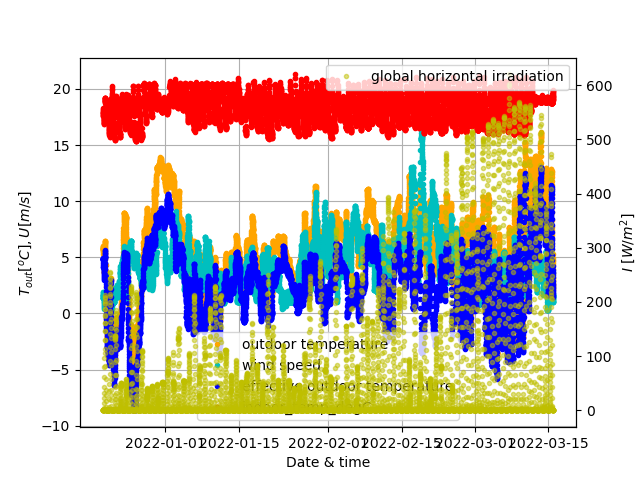

In [28]:
# plot retrieved data

property = 'indoor_temp_degC'

%matplotlib widget
import pylab as plt

fig, ax = plt.subplots()

ax.grid(True)
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)


ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel(r'$I\ [W/m^2]$')
ax2.plot(df_sliced3.index, df_sliced3['hor_irradiation_W_per_m^2'], '.', label='global horizontal irradiation', alpha=0.5, color='y')  # ... and some more.
ax2.legend(loc=1)

ax.plot(df_sliced3.index, df_sliced3['outdoor_temp_degC'], '.', label='outdoor temperature', color='orange')  # Plot some data on the axes.
ax.plot(df_sliced3.index, df_sliced3['windspeed_m_per_s'], '.', label='wind speed', color='c')  # Plot more data on the axes...
ax.plot(df_sliced3.index, df_sliced3['effective_outdoor_temp_degC'], '.', label='effective outdoor temperature', color='b')  # Plot more data on the axes...
ax.plot(df_sliced3.index, df_sliced3[property], '.', label=property, color='r')  # Plot some data on the axes.
ax.legend(loc=0);  # Add a legend.

ax.set_xlabel('Date & time')  # Add an x-label to the axes.
ax.set_ylabel(r'$T_{out} [^oC], U [m/s]$')
plt.show()

# N.B. The resulting figure below can be manipulated interactively; hover with mouse for tips & tricks

In [29]:
# moving_horizon_start = datetime(2021, 12, 21, tzinfo=pytz.timezone(tz_home))
moving_horizon_start = start
moving_horizon_start

datetime.datetime(2021, 12, 20, 0, 0, tzinfo=<DstTzInfo 'Europe/Amsterdam' CET+1:00:00 STD>)

In [30]:
moving_horizon_end = moving_horizon_start + timedelta(days=7)
moving_horizon_end

datetime.datetime(2021, 12, 27, 0, 0, tzinfo=<DstTzInfo 'Europe/Amsterdam' CET+1:00:00 STD>)

In [32]:
df_sliced4 = df_sliced3[moving_horizon_start:moving_horizon_end]

In [33]:
df_sliced4

,homepseudonym,heartbeat,outdoor_temp_degC,windspeed_m_per_s,effective_outdoor_temp_degC,hor_irradiation_J_per_h_per_cm^2,hor_irradiation_W_per_m^2,indoor_temp_degC,indoor_temp_degC_CO2,indoor_setpoint_temp_degC,gas_m^3,e_used_normal_kWh,e_used_low_kWh,e_returned_normal_kWh,e_returned_low_kWh,timedelta,timedelta_s,e_used_net_kWh,e_remaining_heat_kWh,daycompleteness
2021-12-20 00:00:00+01:00,817341,NaN,6.021051,1.604638,4.951292,-1.976263e-323,-5.434722e-323,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 days 00:15:00,900.0,NaN,NaN,NaN
2021-12-20 00:15:00+01:00,817341,NaN,5.981809,1.604638,4.912050,-1.976263e-323,-5.434722e-323,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 days 00:15:00,900.0,NaN,NaN,NaN
2021-12-20 00:30:00+01:00,817341,NaN,5.942567,1.604638,4.872808,-1.976263e-323,-5.434722e-323,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 days 00:15:00,900.0,NaN,NaN,NaN
2021-12-20 00:45:00+01:00,817341,NaN,5.903324,1.604638,4.833566,-1.976263e-323,-5.434722e-323,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 days 00:15:00,900.0,NaN,NaN,NaN
2021-12-20 01:00:00+01:00,817341,2.0,5.868830,1.583000,4.813496,-1.976263e-323,-5.434722e-323,18.300000,68.8,NaN,0.0,0.0,0.002,0.0,0.0,0 days 00:15:00,900.0,0.002,0.002,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-26 23:00:00+01:00,817341,3.0,0.328082,3.881724,-2.259734,-1.976263e-323,-5.434722e-323,18.803333,45.8,19.000000,0.0,0.0,0.008,0.0,0.0,0 days 00:15:00,900.0,0.008,0.008,1.000000
2021-12-26 23:15:00+01:00,817341,3.0,0.373815,3.782884,-2.148107,-1.976263e-323,-5.434722e-323,18.670000,45.9,18.333333,0.0,0.0,0.002,0.0,0.0,0 days 00:15:00,900.0,0.002,0.002,1.000000
2021-12-26 23:30:00+01:00,817341,3.0,0.419549,3.684043,-2.036480,-1.976263e-323,-5.434722e-323,18.556667,46.5,15.000000,0.0,0.0,0.002,0.0,0.0,0 days 00:15:00,900.0,0.002,0.002,1.000000
2021-12-26 23:45:00+01:00,817341,3.0,0.465282,3.585203,-1.924853,-1.976263e-323,-5.434722e-323,18.403333,46.7,15.000000,0.0,0.0,0.006,0.0,0.0,0 days 00:15:00,900.0,0.006,0.006,1.000000


In [34]:
df_sliced4.describe()

,homepseudonym,heartbeat,outdoor_temp_degC,windspeed_m_per_s,effective_outdoor_temp_degC,hor_irradiation_J_per_h_per_cm^2,hor_irradiation_W_per_m^2,indoor_temp_degC,indoor_temp_degC_CO2,indoor_setpoint_temp_degC,gas_m^3,e_used_normal_kWh,e_used_low_kWh,e_returned_normal_kWh,e_returned_low_kWh,timedelta,timedelta_s,e_used_net_kWh,e_remaining_heat_kWh,daycompleteness
count,673.0,669.000000,673.000000,673.000000,673.000000,6.730000e+02,6.730000e+02,669.000000,669.000000,430.000000,669.000000,669.000000,669.000000,669.000000,669.000000,673,673.0,669.000000,669.000000,669.000000
mean,817341.0,2.998505,0.163513,3.018221,-1.848635,1.137951e+01,3.160976e+01,17.874210,56.785999,17.190310,0.006357,0.003939,0.002492,0.000106,0.000052,0 days 00:15:00,900.0,0.006272,0.006272,0.999502
std,0.0,0.038662,4.051000,1.903351,4.113250,2.249660e+01,6.249055e+01,1.138640,7.403370,1.493380,0.027865,0.007306,0.004965,0.000939,0.000426,0 days 00:00:00,0.0,0.007824,0.007824,0.012887
min,817341.0,2.000000,-5.673674,0.085329,-8.638205,-1.976263e-323,-5.434722e-323,15.320000,42.166667,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0 days 00:15:00,900.0,-0.021000,-0.021000,0.666667
25%,817341.0,3.000000,-2.927211,1.259655,-4.564698,-1.976263e-323,-5.434722e-323,16.950000,51.266667,15.702273,0.000000,0.000000,0.000000,0.000000,0.000000,0 days 00:15:00,900.0,0.001000,0.001000,1.000000
50%,817341.0,3.000000,-0.821232,2.615606,-2.597550,-1.976263e-323,-5.434722e-323,18.210000,56.633333,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0 days 00:15:00,900.0,0.004000,0.004000,1.000000
75%,817341.0,3.000000,3.098841,4.739123,1.100063,9.956382e+00,2.765662e+01,18.743333,62.100000,18.000000,0.000000,0.005000,0.004000,0.000000,0.000000,0 days 00:15:00,900.0,0.008000,0.008000,1.000000
max,817341.0,3.000000,8.959971,6.430313,5.646671,9.182288e+01,2.550636e+02,20.296667,70.700000,19.000000,0.207000,0.046000,0.047000,0.021000,0.007000,0 days 00:15:00,900.0,0.047000,0.047000,1.000000


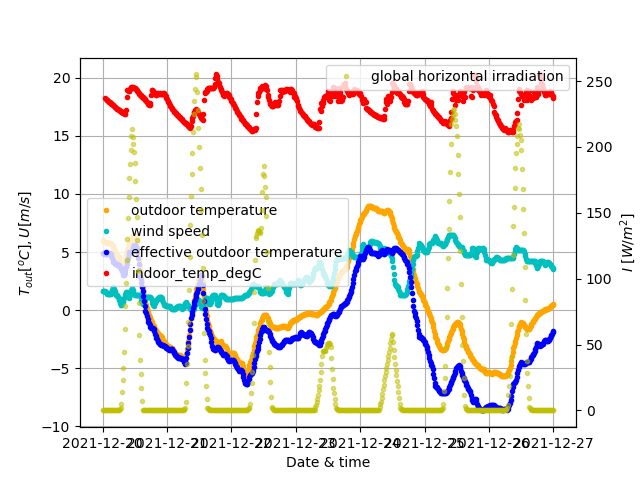

In [37]:
# plot retrieved data

property = 'indoor_temp_degC'

%matplotlib widget
import pylab as plt

fig, ax = plt.subplots()

ax.grid(True)
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)


ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel(r'$I\ [W/m^2]$')
ax2.plot(df_sliced4.index, df_sliced4['hor_irradiation_W_per_m^2'], '.', label='global horizontal irradiation', alpha=0.5, color='y')  # ... and some more.
ax2.legend(loc=1)

ax.plot(df_sliced4.index, df_sliced4['outdoor_temp_degC'], '.', label='outdoor temperature', color='orange')  # Plot some data on the axes.
ax.plot(df_sliced4.index, df_sliced4['windspeed_m_per_s'], '.', label='wind speed', color='c')  # Plot more data on the axes...
ax.plot(df_sliced4.index, df_sliced4['effective_outdoor_temp_degC'], '.', label='effective outdoor temperature', color='b')  # Plot more data on the axes...
ax.plot(df_sliced4.index, df_sliced4[property], '.', label=property, color='r')  # Plot some data on the axes.
ax.legend(loc=0);  # Add a legend.

ax.set_xlabel('Date & time')  # Add an x-label to the axes.
ax.set_ylabel(r'$T_{out} [^oC], U [m/s]$')
plt.show()

# N.B. The resulting figure below can be manipulated interactively; hover with mouse for tips & tricks

In [ ]:
df = data_by_day_total.copy()
df = df.reset_index()
df.rename(columns={'level_0': 'Date_Time'}, inplace=True)

# downsample time to sec
delta_t = 900

print(df.head())

In [ ]:
test_list = []
idx = 0
# for i in range (1):
#     first = df['Date_Time'][idx]
#     second = df['Date_Time'][idx]
#     test_list.append((first, second))
#     idx +=1
    
    
# print(test_list)



test_list.append(df['Date_Time'][0])
print(test_list)



In [ ]:
end_point = df.index[df['Date_Time'] == '2018-11-11 08:00:00'].tolist()[0]

start_time_list = []
end_time_list = []
eta_list = []
h_list = []

duration_01 = 7
num_iter = 50

for j in range(num_iter):
    start_point = end_point
    end_point = start_point + (duration_01 * 24 * 4)

    # data loading
    setpoint = np.asarray(df['indoor_setpoint_temp_degC'].iloc[start_point:end_point])

    T_in_meas = np.asarray(df['indoor_temp_degC'].iloc[start_point:end_point])
    T_out_eff_arr = np.asarray(df['effective_outdoor_temp_degC'].iloc[start_point:end_point])
    time_recorded = df['Date_Time'].iloc[start_point:end_point]
    T_out = np.asarray(df['outdoor_temp_degC'].iloc[start_point:end_point])
    gas_total = np.asarray(df['gas_m^3'].iloc[start_point:end_point])

    e_used_normal_val = np.asarray(df['e_used_normal_kWh'].iloc[start_point:end_point])
    e_used_low_val = np.asarray(df['e_used_low_kWh'].iloc[start_point:end_point])

#     pv_yield_val = np.asarray(df['pv_yield_kWh'].iloc[start_point:end_point])
#     pv_used_val = np.asarray(df['pv_used_kWh'].iloc[start_point:end_point])

    e_returned_normal_val = np.asarray(df['e_returned_normal_kWh'].iloc[start_point:end_point])
    e_returned_low_val = np.asarray(df['e_returned_low_kWh'].iloc[start_point:end_point])

    delta_E_supply_val = np.asarray(e_used_normal_val + e_used_low_val)
    
#     delta_E_PV_val = np.asarray(pv_yield_val - pv_used_val)
    delta_E_PV_val = 0
    
    delta_E_ret_val = np.asarray(e_returned_normal_val + e_returned_low_val)
    delta_EV_charge_val = 0

#     delta_E_CH_val = np.asarray(df['heatpump_kWh'].iloc[start_point:end_point])
    delta_E_CH_val = 0


    delta_E_int_val = np.asarray(
        (delta_E_supply_val + delta_E_PV_val - delta_E_ret_val - delta_EV_charge_val - delta_E_CH_val) / delta_t)   # [kWh/s]
    delta_Q_int_e_val = np.asarray(delta_E_int_val * 1000 * 60 * 60)    # [W]
    I_geo_eff_val = np.asarray(df_solar['hor_irradiation_W_per_m^2'].iloc[start_point:end_point])

    ########################################################################################################################
    #                                                   tau initial values input
    ########################################################################################################################
    # tau Input: the following value should be based on hour for tau [hr]
    tau_init_val_hr = 100
    tau_lb_hr = 10
    tau_ub_hr = 1000

    # Internal conversion (do not change this part)
    tau_init_val = tau_init_val_hr * 3600
    tau_lb = tau_lb_hr * 3600
    tau_ub = tau_ub_hr * 3600

    ########################################################################################################################
    #                                                   Gekko Model - Initialize
    ########################################################################################################################
    # initialize gekko
    m = GEKKO(remote=False)
    m.time = np.linspace(delta_t, len(T_in_meas) * delta_t, len(T_in_meas))  # [s]

    ########################################################################################################################
    #                                                   Gekko Model - Variables
    ########################################################################################################################
    """"
    Model parameter:
    tau [hr]: effective thermal inertia
    eta_hs_CH [-]: upper heating efficiency of the central heating system
    COP_CH [-]: Coef. of Performance for heat pump
    H [W/K]: specific heat loss
    A_eff [m^2]: Effective area of the imaginary solar aperture in the horizontal plane
    """
    tau = m.FV(value=tau_init_val, lb=tau_lb, ub=tau_ub);
    tau.STATUS = 1;
    tau.FSTATUS = 0;  # tau.DMAX = 10
    H = m.FV(value=300.0, lb=0, ub=1000);
    H.STATUS = 1;
    H.FSTATUS = 0;  # H.DMAX=50                #[W/K]
    # eta_hs_CH = m.FV(value=0.8, lb=0, ub=1.0); eta_hs_CH.STATUS = 1; eta_hs_CH.FSTATUS = 0;  # eta_hs_CH.DMAX = 0.25
    # COP_CH = m.FV(value=1, lb=0.1, ub=7) ; COP_CH.STATUS = 1 ; COP_CH.FSTATUS = 0 ; #COP_CH.DMAX=1
    A_eff = m.FV(value=5, lb=1, ub=100) ; A_eff.STATUS = 1 ; A_eff.FSTATUS = 0            #[m^2]

    """"
    Constant parameter:
    h_E [J/kWh]: Convertion factor ( [kWh] to [J] ) = 1000 * 60 * 60

    h_sup [J/Nm^3]: superior calorific value of natural gas from the Groningen field = 35,170,000.00
    eta_hs_noCH [-]: upper efficiency of heating the home indirectly using gas, for other primary purposes than heating the home

    delta_Q_sol [J/s]: heat gain from solar irradiation
    delta_G_noCH [Nm^3/s]: the natural gas used for other purposes than central heating
    delta_Q_int_gas_noCH [J/s]: natural gas used for central heating

    delta_Q_int_occup [W]: internal heat gain from occupants
    delta_Q_int_occup [W] = Np * Q_int_person_avg [W]
    Np [-]: number of persons in the household living in the home
    Q_int_person_avg [W]: internal heat gain from persons
    """
    h_E = m.Param(value=60 * 60 * 1000)  # [J/kWh"], the conversion factor [kWh] to [J]
    h_sup = m.Param(value=35170000.0)  # [J/Nm^3] "superior calorific value of natural gas from the Groningen field"
    eta_hs_noCH = m.Param(value=0.34)  # eq48. and PowerPoint Slide 24 (Effective upper home for indirect heating eff.)

    eta_hs_CH = m.Param(value=0.9)
    COP_CH = m.Param(value=4)
    # A_eff = m.Param(value=6)

    delta_G_noCH = m.Param(value=339.0 / (365.25 * 24 * 60 * 60))  # [Nm^3/s]
    delta_Q_int_gas_noCH = m.Param(value=delta_G_noCH * eta_hs_noCH * h_sup)  # [W]=[J/s]

    Np = m.Param(value=2.2)  # average number of people in Dutch household
    Q_int_person_avg = m.Param(value=61)  # [J/s] average heat gain for each average person with average behaviour
    delta_Q_int_occup = m.Param(value=Np * Q_int_person_avg)  # [J/s]

    """"
    Manipulated parameter:
    delta_Q_int_e [J/s]: internal heat gain from internally used electricity
    delta_Q_int_e [J/s] = delta_E_int [kWh/s] * hE [J/kWh]
    T_out_eff [K]: effective outdoor temperature
    delta_E_CH [kWh]: Electricity used for heat pump
    delta_G [Nm3/s] = Natural gas supplied to the home via the natural gas net
    I_geo_eff [W/m^2] = geospatially interpolated global horizontal irradiation
    """
    delta_Q_int_e = m.MV(value=delta_Q_int_e_val);
    delta_Q_int_e.STATUS = 0;
    delta_Q_int_e.FSTATUS = 1  # [J/s]
    T_out_eff = m.MV(value=T_out_eff_arr);
    T_out_eff.STATUS = 0;
    T_out_eff.FSTATUS = 1  # [K]
    delta_E_CH = m.MV(value=delta_E_CH_val / delta_t);
    delta_E_CH.STATUS = 0;
    delta_E_CH.FSTATUS = 1  # [kWh/s]
    delta_G = m.MV(value=gas_total / delta_t);
    delta_G.STATUS = 0;
    delta_G.FSTATUS = 1  # [Nm^3/s]
    I_geo_eff = m.MV(value=I_geo_eff_val);
    I_geo_eff.STATUS = 0;
    I_geo_eff.FSTATUS = 1

    """"
    Control variable:
    T_in_sim [K]: Indoor temperature
    """
    T_in_sim = m.CV(value=T_in_meas);
    T_in_sim.STATUS = 1;
    T_in_sim.FSTATUS = 1;  # T_in_sim.MEAS_GAP= 0.25

    ########################################################################################################################
    #                                               Gekko - Equations
    ########################################################################################################################
    """
    delta_Q_gain [J/s]= delta_Q_CH [J/s] + delta_Q_int [J/s] + delta_Q_sol [J/s]
    delta_Q_gain [J/s]= Heat gain
    delta_Q_CH [J/s]= Heat gain from central hearting
    delta_Q_int [J/s]= Heat gain from internal devices
    delta_Q_sol [J/s]= delta_Q_int from solar irradiation
    """

    ########################################################################################################################
    #                                               Equation - delta_Q_CH
    ########################################################################################################################
    """"
    delta_Q_CH [J/s] = (delta_G_CH [Nm3/s] * eta_hs_ch [-] * h_sup [J/Nm3]) + (delta_E_CH [kWh/s] * COP_CH [-] * hE [J/kWh])
    delta_G_CH [Nm3/s] = Natural gas used for central heating
    delta_G_CH [Nm3/s] = delta_G [Nm3/s]- delta_G_noCH [Nm3/s]
    """

    delta_G_CH = m.Intermediate(delta_G - delta_G_noCH)  # [Nm3/s]
    delta_Q_CH = m.Intermediate((delta_G_CH * eta_hs_CH * h_sup) + (delta_E_CH * COP_CH * h_E))  # [J/s]
    # delta_Q_CH = m.Intermediate((delta_Q_CH * eta_hs_CH * h_sup) + (delta_E_CH * COP_CH * h_E))  # [J/s]
    ########################################################################################################################
    #                                                   Equation - delta_Q_int
    ########################################################################################################################
    """"
    delta_Q_int [J/s]: total internal heat
    delta_Q_int [J/s]= delta_Q_int_e + delta_Q_int_occup + delta_Q_int_gas_noCH
    delta_E_int [kWh/s] = delta_E_supply [kWh/s] + delta_E_PV [kWh/s] - delta_E_ret [kWh/s] - delta_E_EVcharge [kWh/s]
    """
    delta_Q_int = m.Intermediate(delta_Q_int_e + delta_Q_int_occup + delta_Q_int_gas_noCH)  # [J/s]

    ########################################################################################################################
    #                                                   Equation - delta_Q_sol
    ########################################################################################################################
    delta_Q_sol = m.Intermediate(A_eff * I_geo_eff)  # [J/s]

    ########################################################################################################################
    #                                                    Equation - delta_Q_gain
    ########################################################################################################################
    delta_Q_gain = m.Intermediate(delta_Q_CH + delta_Q_sol + delta_Q_int)  # [J/s]

    ########################################################################################################################
    #                                                   Final Equations
    ########################################################################################################################
    C_eff = m.Intermediate(H * tau)
    m.Equation(T_in_sim.dt() == (delta_Q_gain - (H * (T_in_sim - T_out_eff))) / C_eff)

    ########################################################################################################################
    #                                                    Solve Equations
    ########################################################################################################################
    m.options.IMODE = 5
    m.options.EV_TYPE = 1  # specific objective function (L1-norm vs L2-norm)
    m.options.NODES = 2
    # m.options.CV_TYPE = 2
    # add dead-band for measurement to avoid overfitting
    # T_in_sim.MEAS_GAP = 0.25
    m.solve(disp=False)

    ########################################################################################################################
    #                                                       Result
    ########################################################################################################################
    print(
        "Start point: {} ====> End point: {}".format(df.loc[start_point, 'Date_Time'], df.loc[end_point, 'Date_Time']))
    print('Iter: ', j)
    print('effective thermal inertia: tau [hr]: ' + str(round(tau.value[0] / 3600, 2)))
    # print('upper heating efficiency of the central heating system: eta_hs [-]: ' + str(round(eta_hs_CH.value[0], 2)))
    # print('Coef. of Performance for heat pump: COP_CH [-]: ' + str(round(COP_CH.value[0], 2)))
    print('specific heat loss: H [W/K]: ' + str(round(H.value[0], 2)))
    print('Effective area of solar aperture in the horizontal plane: A_eff [m^2]: ' + str(round(A_eff.value[0], 2)))
    print('*' * 50)

    row_num = printing_row + j
    wb = openpyxl.load_workbook(filename='result.xlsx')
    ws = wb.worksheets[1]
    ws.cell(row=row_num, column=1).value = flat_pseudonym
    ws.cell(row=row_num, column=2).value = df['Date_Time'][start_point]
    ws.cell(row=row_num, column=3).value = df['Date_Time'][end_point]
    ws.cell(row=row_num, column=4).value = duration_01
    ws.cell(row=row_num, column=5).value = A_eff.value[0]
    ws.cell(row=row_num, column=6).value = COP_CH.value[0]
    ws.cell(row=row_num, column=7).value = round(eta_hs_CH.value[0], 2)
    ws.cell(row=row_num, column=8).value = round(tau.value[0] / 3600, 2)
    ws.cell(row=row_num, column=9).value = round(H.value[0], 2)
    wb.save("result.xlsx")


#     time_interval_list.append((df['Date_Time'][start_point], df['Date_Time'][end_point]))
#     eta_list.append(round(tau.value[0] / 3600, 2))
#     h_list.append(round(H.value[0], 2))


In [ ]:
    row_num = 1
    wb = openpyxl.load_workbook(filename='result.xlsx')
    ws = wb.worksheets[0]
    ws.cell(row=row_num, column=1).value = 2
    ws.cell(row=row_num, column=2).value = 3
    wb.save("result.xlsx")

In [ ]:
%%time
#initially, we only analyze 4 weeks early January 2019: 4 FEB 2019 TM 3 MRT 2019
# start = datetime(2019, 2, 3)
# end = datetime(2019, 3, 4)

#subsequently, we analyze 1st heating season: Sep 1, 2018 tm 30 apr 2019
#subsequently, we analyze 2nd heating season: Sep 1, 2019 tm 30 apr 2019

# finally, analyse everything: 26-4-2018 tm 24-nov-2020
start = datetime(2018, 4, 25)
end = datetime(2020, 11, 21)

upsample = '5min'
downsample = '15min'
#TODO: check  whether KNMI source data is defined in UTC, if not, change and debug localization
tz_system = 'UTC'
tz_home = 'Europe/Amsterdam'

# any house in Berkum will do; these all lead to the same KNMI weather 
pseudonym = 934457
    
outdoor_temp_by_day = get_weather_parameter_timeseries_mean(pseudonym, 'OutdoorTemperature', 'outdoor_temp_degC', 
                                                            upsample, downsample, start, end, tz_home)
windspeed_by_day = get_weather_parameter_timeseries_mean(pseudonym, 'WindSpeed', 'windspeed_m_per_s', 
                                                            upsample, downsample, start, end, tz_home)
irradiation_by_day = get_weather_parameter_timeseries_mean(pseudonym, 'HorizontalIrradiation', 'hor_irradiation_W_per_m^2', 
                                                            upsample, downsample, start, end, tz_home)

# merge weather data in a single dataframe
weather_by_day = pd.concat([outdoor_temp_by_day, windspeed_by_day, irradiation_by_day], axis=1, join='outer') 
#calculate effective outdoor temperature based on KNMI formula
weather_by_day['effective_outdoor_temp_degC'] = weather_by_day['outdoor_temp_degC'] - 2/3 * weather_by_day['windspeed_m_per_s'] 


weather_by_day.tz_localize(None).to_excel('weather.xlsx')
weather_by_day['outdoor_temp_degC'].plot()
weather_by_day['effective_outdoor_temp_degC'].plot()
weather_by_day['hor_irradiation_W_per_m^2'].plot()
weather_by_day['windspeed_m_per_s'].plot()
print(weather_by_day.describe())


In [ ]:
data_by_day_total.describe()

In [ ]:
indoor_setpoint_by_day.head(100)

In [ ]:
data_by_day['e_used_net_kWh'] = data_by_day['e_used_normal_kWh'] + data_by_day['e_used_low_kWh']- data_by_day['e_returned_normal_kWh'] - data_by_day['e_returned_low_kWh'] + data_by_day['pv_yield_kWh'] - data_by_day['pv_used_kWh']
#  )
print(data_by_day.describe())

In [ ]:
%%time 
import matplotlib.pyplot as plt

start = datetime(2018, 4, 1)
end = datetime(2020, 12, 31)
fullset = [901216, 912336, 917629, 918349, 919110, 921286, 921767, 922325, 928292, 934457, 
                   935323, 935869, 937111, 940703, 940957, 944008, 944999, 946938, 951667, 952553, 
                   956719, 959010, 959403, 959885, 962398, 965160, 970156, 971591, 973327, 973834, 
                   978454, 983811, 983987, 986699, 986715, 988752, 990642, 991561, 991990, 992752, 
                   992890, 993143, 993705, 999071, 999749, 999890]
smallset =  [901216, 912336, 917629, 919110, 921286, 921767]
problematicset = [921286, 921767, 944008]

# iterator = list(set(fullset) - set(problematicset))
# iterator = list(set(problematicset))
           
for pseudonym in [921286, 921767, 944008]: 
    extractor = Extractor(pseudonym, Period(start, end))
    # get heat pump meter readings
    data_kwh = extractor.get('ElectricityUsedLow')
    data_kwh['datetime'] = pd.to_datetime(data_kwh['datetime'])
    data_kwh.set_index('datetime', inplace=True)
    
    #first sort on datetime index
    data_kwh.sort_index(inplace=True)
    oldlen =len(data_kwh)
    #then deduplicate the series
    data_kwh.drop_duplicates(inplace=True)
    newlen = len(data_kwh)
    
    # calculate diff, filter out the negative jumps and recalculate the meter value, starting at zero
    data_kwh['value_monotonic'] = data_kwh['value'].diff().fillna(0).clip(0,None).cumsum()
    
   
    # data_kwh_minute = data_kwh.resample('1min').first()
    # data_kwh_minute.rename(columns={'value':'heatpumpmeter_kWh'}, inplace=True)
    # data_kwh_minute['value_diff'] = data_kwh_minute['value_kWh'].diff().shift(-1)
    # data_kwh_minute['value_diff'] = heatpump_kwh_minute['value_diff'].fillna(0)
    # data_kwh_minute = data_kwh_minute['value_diff'].resample('1D').sum()
    print("pseudonym:", pseudonym, "length:", len(data_kwh), "stringpseudonym:", str(pseudonym))
    if oldlen > newlen:
        print("duplicates removed: ", oldlen-newlen)

    if (len(data_kwh))>0: 
        plt.plot(data_kwh['value_monotonic'],'g-')
        plt.plot(data_kwh['value'], 'r.')
        plt.legend([str(pseudonym)])
        plt.show()


In [ ]:
#first, get the negative jumps out
data_kwh['positivediffs'] = data_kwh['value_diff'].clip(0,None).cumsum()
plt.plot(data_kwh['positivediffs'], 'b.')
plt.plot(data_kwh['value'], 'r.')

In [ ]:
data_kwh


In [ ]:
%%time 
start = datetime(2018, 1, 1)
end = datetime(2020, 12, 31)
for pseudonym in [901216, 912336, 917629, 918349, 919110, 921286, 921767, 922325, 928292, 934457, 
                   935323, 935869, 937111, 940703, 940957, 944008, 944999, 946938, 951667, 952553, 
                   956719, 959010, 959403, 959885, 962398, 965160, 970156, 971591, 973327, 973834, 
                   978454, 983811, 983987, 986699, 986715, 988752, 990642, 991561, 991990, 992752, 
                   992890, 993143, 993705, 999071, 999749, 999890]:
    #check energycentral heating for 921767
    extractor = Extractor(pseudonym, Period(start, end))
    # get heat pump meter readings
    data_kwh = extractor.get('IndoorTemperature')
    data_kwh['datetime'] = pd.to_datetime(data_kwh['datetime'])
    data_kwh.set_index('datetime', inplace=True)
    # data_kwh_minute = data_kwh.resample('1min').first()
    # data_kwh_minute.rename(columns={'value':'heatpumpmeter_kWh'}, inplace=True)
    # data_kwh_minute['value_diff'] = data_kwh_minute['value_kWh'].diff().shift(-1)
    # data_kwh_minute['value_diff'] = heatpump_kwh_minute['value_diff'].fillna(0)
    # data_kwh_minute = data_kwh_minute['value_diff'].resample('1D').sum()
    data_kwh['value'].plot()

In [ ]:
%%time

start = datetime(2018, 1, 1)
end = datetime(2020, 12, 1)

upsample = '5min'
downsample = '1D'
tz_system = 'UTC'
tz_home = 'Europe/Amsterdam'

# any house in Berkum will do; these all lead to the same KNMI weather 
pseudonym = 934457
    
#the WeatherExtractor uses the database
# weatherextractor = WeatherExtractor(pseudonym, Period(start, end))

# #get outdoor temperatures
# outdoor_temp = weatherextractor.get('OutdoorTemperature')
# outdoor_temp.set_index('datetime', inplace=True)
# outdoor_temp.drop(columns=['index', 'timestamp'], inplace=True)
# outdoor_temp.rename(columns={'value':'outdoor_temp_degC'}, inplace=True)

outdoor_temp_by_day = get_weather_parameter_timeseries_mean(pseudonym, 'OutdoorTemperature', 'outdoor_temp_degC', 
                                                            upsample, downsample, start, end, tz_home)


print(outdoor_temp_by_day)
outdoor_temp_by_day.describe()
outdoor_temp_by_day.plot()


In [ ]:
%%time
#initially, we only analyze 4 weeks early January 2019: 4 FEB 2019 TM 3 MRT 2019
#subsequently, we analyze 1st heating season: Sep 1, 2018 tm 30 apr 2019
#subsequently, we analyze 2nd heating season: Sep 1, 2019 tm 30 apr 2019
#finally, analyse everything: 26-4-2018 tm 24-nov-2020

start = datetime(2019, 2, 3)
end = datetime(2019, 6, 4)

# any house in Berkum will do; these all lead to the same KNMI weather 
pseudonym = 934457

upsample = '1min'
downsample = '1D'
tz_system = 'UTC'
tz_home = 'Europe/Amsterdam'
        
indoor_temp_by_day = get_home_parameter_timeseries_mean(pseudonym, 'IndoorTemperature', 'indoor_temp_degC', 
                                         upsample, downsample, start, end, tz_home)
print(indoor_temp_by_day)
indoor_temp_by_day.describe()

In [ ]:
indoor_temp_by_day.plot()

In [ ]:
%%time 
#initially, we only analyze 4 weeks early January 2019: 4 FEB 2019 TM 3 MRT 2019
start = datetime(2019, 2, 3)
end = datetime(2019, 3, 4)

#subsequently, we analyze 1st heating season: Sep 1, 2018 tm 30 apr 2019
#subsequently, we analyze 2nd heating season: Sep 1, 2019 tm 30 apr 2019

# finally, analyse everything: 26-4-2018 tm 24-nov-2020
# start = datetime(2018, 4, 25)
# end = datetime(2020, 11, 21)
upsample = '5min'
downsample = '1D'
tz_system = 'UTC'
tz_home = 'Europe/Amsterdam'

data_by_day_total = pd.DataFrame()
for pseudonym in [901216, 912336, 917629, 918349, 919110, 921286, 921767, 922325, 928292, 934457, 
                   935323, 935869, 937111, 940703, 940957, 944008, 944999, 946938, 951667, 952553, 
                   956719, 959010, 959403, 959885, 962398, 965160, 970156, 971591, 973327, 973834, 
                   978454, 983811, 983987, 986699, 986715, 988752, 990642, 991561, 991990, 992752, 
                   992890, 993143, 993705, 999071, 999749, 999890]:
# for pseudonym in [944008, 901216, 986715]:
# for pseudonym in [944008]:
    print(pseudonym)
    heartbeats_by_day = get_home_parameter_timeseries_count(pseudonym, 'HeartBeat', 'heartbeat', False, upsample, downsample, start, end, tz_home)
    home_by_day = heartbeats_by_day
    home_by_day['homepseudonym'] = pseudonym
    data_by_day = home_by_day
    data_by_day['timedelta'] = data_by_day.index.to_series().diff().shift(-1)
    data_by_day['timedelta_s'] = data_by_day['timedelta'].apply(lambda x: x.total_seconds())


    data_by_day_total = pd.concat([data_by_day_total,data_by_day.set_index('homepseudonym', append=True)], axis=0)

#     filename = './'+str(pseudonym)+'.xlsx'
#     #strip timezone info before exporting to (Excel doet not support timezone)
#     data_by_day.tz_localize(None).to_excel(filename)
# data_by_day_total.tz_localize(None, level=0).to_excel('./allhomes.xlsx')
print(data_by_day_total.describe())

In [ ]:
data_by_day